# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

In [ ]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (4.8, 3.2)
import urllib
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

from math import exp, sqrt, log, pi, sin, cos, atan, tan
import math
import cmath
from cmath import exp as cexp
from cmath import sqrt as csqrt
from cmath import log as clog
from cmath import phase as phase
from cmath import polar as polar

from functools import partial
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.model_selection import train_test_split

import scipy
from scipy import optimize, stats
from scipy.optimize import minimize

from random import gauss, uniform
from tqdm.notebook import tqdm

from scipy.special import gamma as gamma_func
import mpmath as mp  # with special hypergeometric functions
from scipy.special import hyp2f1 as hyp_2f1

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings

warnings.filterwarnings("ignore")  # to suppress warning messages
import itertools

# Sample IV surface values

In [73]:
# based on the grid:
S0 = 100
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

In [74]:
# xi,eta,kappa,rho
def print_params(x):
    print(
        "xi = " + str(x[0]),
        "\n",
        "kappa1 = " + str(x[1]),
        "\n",
        "eta1 = " + str(x[2]),
        "\n",
        "eta2 = " + str(x[3]),
        "\n",
        "rho = " + str(x[4]),
    )

In [455]:
S0 = 100
raw_data = np.load(f"new_preprocessing_T0_1_k50.npy")

X = raw_data[:, :5]
target_y = raw_data[:, 5:]
print("X shape:", X.shape)
print("Y shape:", target_y.shape)
# 4 params + 88 option prices (11 prices for each 8 maturities slice by slice starting from shortest maturity:)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

X shape: (107121, 5)
Y shape: (107121, 88)


In [456]:
# print parameters
print_params(X[100])

xi = 0.2358819299727391 
 kappa1 = 35.16504451426415 
 eta1 = 12.888972411980708 
 eta2 = 3.712474548669425 
 rho = -0.14158913974960965


5. Split the Data between training (85%) and testing (15%) and normalise inputs between $[-1,1]$ and center/standardise outputs. 

In [457]:
# splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T, X), axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42
)

train_index = X_train[:, 0].astype(int)
test_index = X_test[:, 0].astype(int)
X_train = X_train[:, 1:]
X_test = X_test[:, 1:]

In [458]:
X_indexed[:, 1:].min(axis=0)

array([ 0.03003364, 10.00010147,  5.00113742,  1.0001183 , -0.76138665])

In [459]:
X_indexed[:, 1:].max(axis=0)

array([ 0.24999957, 59.99992585, 34.99960608,  4.9999514 , -0.10000203])

In [460]:
# Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x - x_min) / (x_max - x_min) * (norm_max - norm_min) + norm_min


def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm - norm_min) / (norm_max - norm_min) * (x_max - x_min) + x_min


x_max = X_indexed[:, 1:].max(axis=0)
x_min = X_indexed[:, 1:].min(axis=0)
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

In [461]:
# Standardising output data y to the interval, so it is centred with variance 1
def output_norm_transform(y, mean, std):
    return (y - mean) / std


def output_norm_transform_inv(y_trans, mean, std):
    return y_trans * std + mean


y_mean = np.average(y_train, axis=0)
y_std = np.std(y_train, axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

# Building the neural networks

6. Build a neural network using Sequential with 3 hidden layer with 30 neurons each using elu activation function for hidden layer. Then compile and train the model using adam optimizer and suitable loss function.

In [462]:
model_iv = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="elu", input_shape=(5,)),
        keras.layers.Dense(30, activation="elu"),
        keras.layers.Dense(30, activation="elu"),
        keras.layers.Dense(y_train_transform.shape[1], activation="linear"),
    ]
)

model_iv.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 30)                180       
                                                                 
 dense_73 (Dense)            (None, 30)                930       
                                                                 
 dense_74 (Dense)            (None, 30)                930       
                                                                 
 dense_75 (Dense)            (None, 88)                2728      
                                                                 
Total params: 4768 (18.62 KB)
Trainable params: 4768 (18.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [463]:
# RMSE error function
def error_function(y_true, y_pred):
    return tf.sqrt(tf.math.reduce_mean((y_pred - y_true) ** 2))

In [464]:
model_iv.compile(optimizer="ADAM", loss=error_function)

In [465]:
train_hist = model_iv.fit(
    x_train_transform, y_train_transform, batch_size=200, epochs=100
)

Epoch 1/50


456/456 [==============================] - 0s 683us/step - loss: 0.3545
Epoch 2/50
456/456 [==============================] - 0s 697us/step - loss: 0.1853
Epoch 3/50
456/456 [==============================] - 0s 693us/step - loss: 0.1675
Epoch 4/50
456/456 [==============================] - 0s 693us/step - loss: 0.1567
Epoch 5/50
456/456 [==============================] - 0s 703us/step - loss: 0.1470
Epoch 6/50
456/456 [==============================] - 0s 696us/step - loss: 0.1388
Epoch 7/50
456/456 [==============================] - 0s 904us/step - loss: 0.1334
Epoch 8/50
456/456 [==============================] - 0s 684us/step - loss: 0.1299
Epoch 9/50
456/456 [==============================] - 0s 687us/step - loss: 0.1274
Epoch 10/50
456/456 [==============================] - 0s 689us/step - loss: 0.1255
Epoch 11/50
456/456 [==============================] - 0s 680us/step - loss: 0.1241
Epoch 12/50
456/456 [==============================] - 0s 677us/step - loss: 0.1230
Epoch 13/50


In [466]:
# model_iv.save_weights("2FBergomiNNWeights_new.h5")

In [485]:
NNParameters = []
for i in range(0, len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

In [486]:
len(NNParameters[0][0])

5

### Transfer the learned NN to Numpy

This step is not mandatory but (!) To accelerate the calibration, we transfer the NN to numpy

In [487]:
NNParameters = []
for i in range(0, len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

NumLayers = 3


def elu(x):
    # Careful function ovewrites x
    ind = x < 0
    x[ind] = np.exp(x[ind]) - 1
    return x


def eluPrime(y):
    # we make a deep copy of input x
    x = np.copy(y)
    ind = x < 0
    x[ind] = np.exp(x[ind])
    x[~ind] = 1
    return x


def NeuralNetwork(x):
    input1 = x
    for i in range(NumLayers):
        input1 = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        # Elu activation
        input1 = elu(input1)
    # The output layer is linnear
    i += 1
    return np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]


def NeuralNetworkGradient(x):
    input1 = x
    # Identity Matrix represents Jacobian with respect to initial parameters
    grad = np.eye(5)
    # Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1 = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        grad = np.einsum("ij,jk->ik", grad, NNParameters[i][0])
        # Elu activation
        grad *= eluPrime(input1)
        input1 = elu(input1)
    # input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad = np.einsum("ij,jk->ik", grad, NNParameters[i + 1][0])
    # grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

## Validating Neural Network results

Validate the Neural Networks results

### Checking the training set

In [488]:
y_pred = output_norm_transform_inv(NeuralNetwork(x_train_transform), y_mean, y_std)

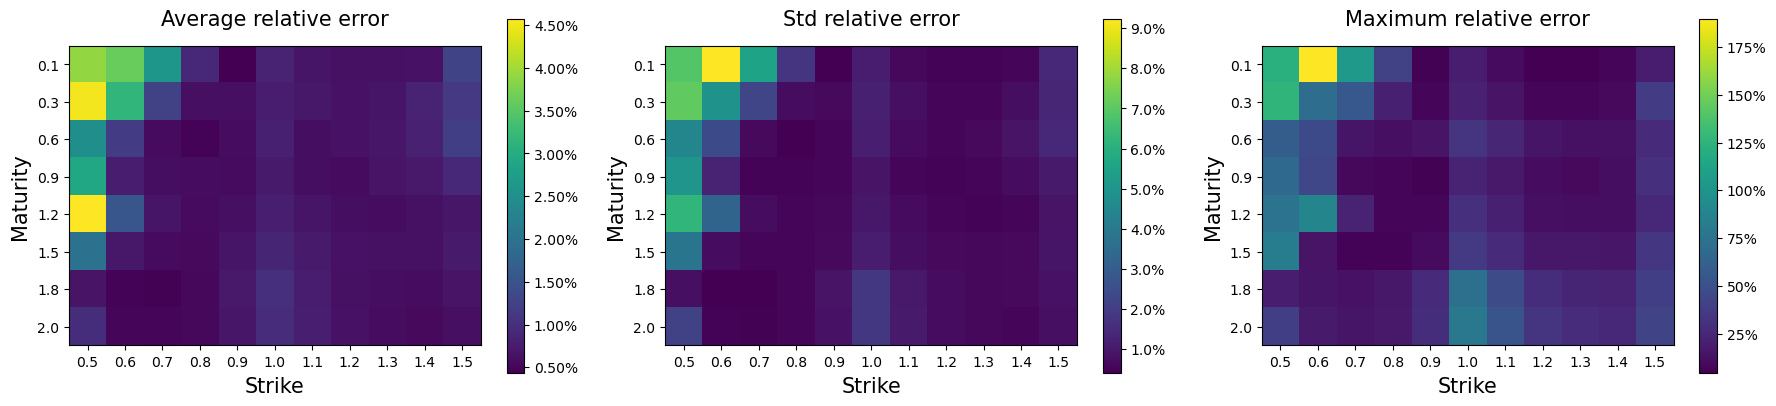

In [489]:
strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikeslabel = np.round(np.linspace(strikes[0], strikes[-1], 8), 1)
maturitieslabel = np.array([0.1, 0.2, 0.6, 1.5, 1.8])
##### AVERAGE VALUES #######

plt.figure(1, figsize=(18, 4))
ax = plt.subplot(1, 3, 1)
err = np.mean(100 * np.abs((y_train - y_pred) / y_train), axis=0)
plt.title("Average relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 2)
err = 100 * np.std(np.abs((y_train - y_pred) / y_train), axis=0)
plt.title("Std relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 3)
err = 100 * np.max(np.abs((y_train - y_pred) / y_train), axis=0)
plt.title("Maximum relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)
plt.tight_layout()
plt.show()

The training shows tha the highest errors are indeed for the data where we had to fit the NaN values to a parabola. However, the scale of the relative error is still small on average

### Checking the test set

In [490]:
y_pred = output_norm_transform_inv(NeuralNetwork(x_test_transform), y_mean, y_std)

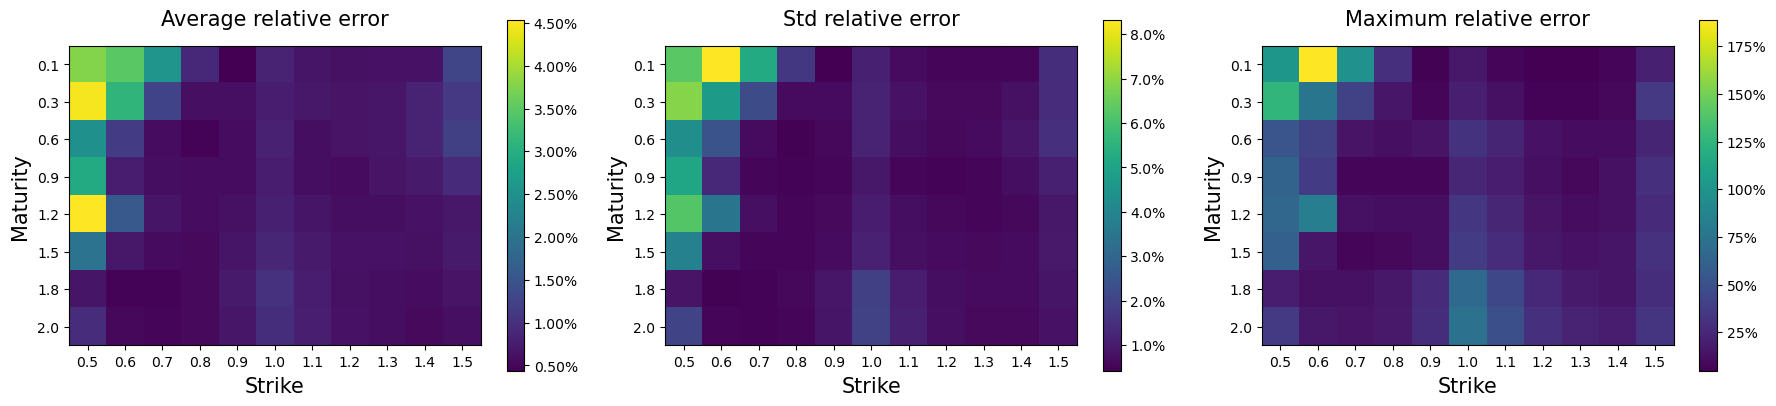

In [491]:
strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikeslabel = np.round(np.linspace(strikes[0], strikes[-1], 8), 1)
maturitieslabel = np.array([0.1, 0.2, 0.6, 1.5, 1.8])
##### AVERAGE VALUES #######

plt.figure(1, figsize=(18, 4))
ax = plt.subplot(1, 3, 1)
err = np.mean(100 * np.abs((y_test - y_pred) / y_test), axis=0)
plt.title("Average relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 2)
err = 100 * np.std(np.abs((y_test - y_pred) / y_test), axis=0)
plt.title("Std relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1, 3, 3)
err = 100 * np.max(np.abs((y_test - y_pred) / y_test), axis=0)
plt.title("Maximum relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim, strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes / 100)
ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)
plt.tight_layout()
plt.show()

The performance on the test set is similar to the trin set, suggesting that the network is not overfit

xi = 0.20138797128578997 
 kappa1 = 33.618992527239776 
 eta1 = 34.8341405473288 
 eta2 = 3.6266046260492986 
 rho = -0.22101986471377372


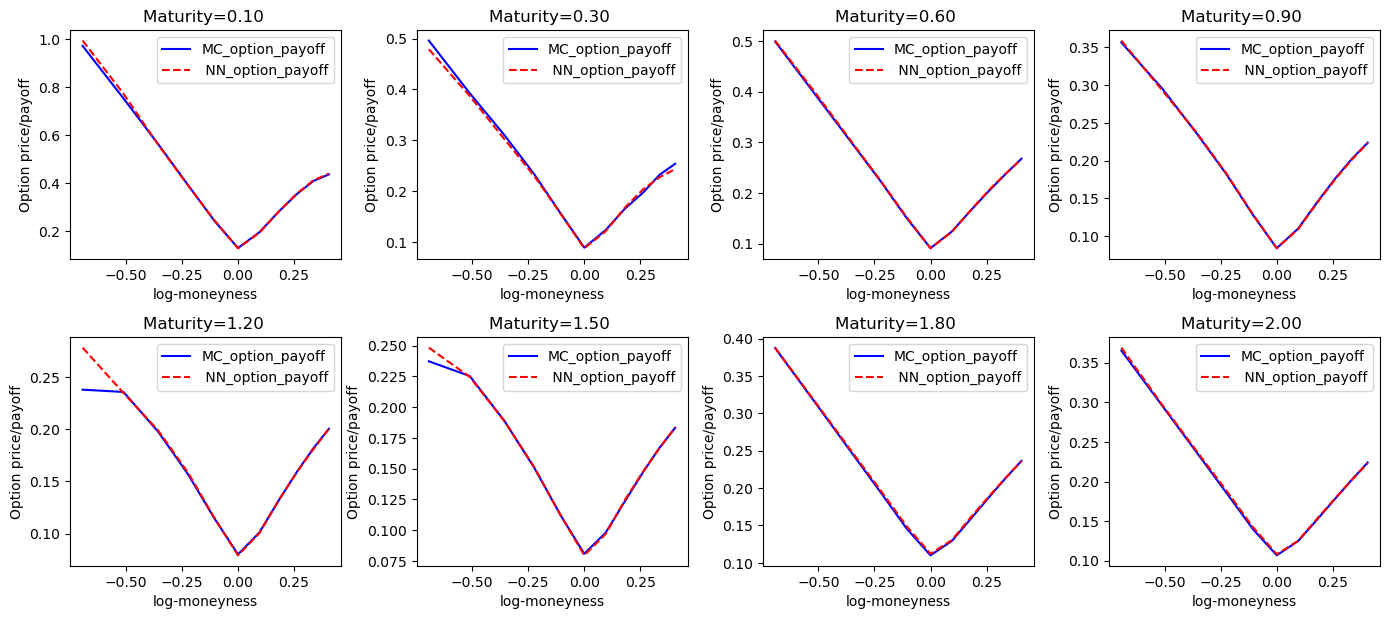

In [492]:
sample_ind = 10
X_input = X_test[sample_ind]
X_input_transform = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)
y_true = y_test[sample_ind]
print_params(X_input)

prediction = output_norm_transform_inv(NeuralNetwork(X_input_transform), y_mean, y_std)
plt.figure(1, figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(
        np.log(strikes / S0),
        y_true[i * strikes_dim : (i + 1) * strikes_dim],
        "b",
        label="MC_option_payoff",
    )
    plt.plot(
        np.log(strikes / S0),
        prediction[i * strikes_dim : (i + 1) * strikes_dim],
        "--r",
        label=" NN_option_payoff",
    )

    plt.title("Maturity=%1.2f " % maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Option price/payoff")

    plt.legend()
plt.tight_layout()
plt.show()

The NN appears to fit the data well

In [505]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(xi0,kappa1,eta1, eta2, rho):
    x0 = input_norm_transform(np.array([xi0,kappa1,eta1, eta2, rho]), x_min, x_max, x_norm_min, x_norm_max)
    Smiles = output_norm_transform_inv(NeuralNetwork(x0).reshape(1,-1), y_mean, y_std)
    plt.figure(1,figsize=(14,12))
    for i in range(8):
        plt.subplot(4,4,i+1)

        
        plt.plot(np.log(strikes / S0),Smiles[0,i*strikes_dim:(i+1)*strikes_dim],'b',label=" NN Approx")

        #plt.ylim(0.1,0.8)
        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.03,
                                               max=0.25,
                                               step=0.01),
        kappa1 = widgets.FloatSlider(value=15,
                                               min=10,
                                               max=60,
                                               step=0.1),
        eta1 = widgets.FloatSlider(value=25,
                                               min=5,
                                               max=35,
                                               step=0.1),
        eta2 = widgets.FloatSlider(value=2.5,
                                               min=1,
                                               max=5,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.6,
                                               min=-0.9,
                                               max=-0.1,
                                               step=0.05))


interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.25, min=0.03, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, kappa1, eta1, eta2, rho)>

# Calibrate to SPX volatility surface 5/12/2017

In [494]:
spx_surface = np.loadtxt(
    "/Users/aadhar/Downloads/DEEP_FIN_PROJ_1/spx_surface.csv", delimiter=","
).flatten()

In [495]:
# Cost Function for Levenberg Marquardt - not used
def CostFuncLS(x):
    spx_transform = output_norm_transform(spx_surface, y_mean, y_std)
    return NeuralNetwork(x) - spx_transform


init = np.zeros(X.shape[1])
opt_res = scipy.optimize.least_squares(CostFuncLS, init, gtol=1e-15)
print(opt_res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.904e-02 -1.458e-01 ...  2.318e-01  3.791e-01]
           x: [-9.301e-01  9.490e-01  7.296e-01 -1.880e+00 -1.598e+00]
        cost: 8.594898647529108
         jac: [[ 5.574e+00 -2.708e+00 ...  1.609e+00 -1.400e+00]
               [ 5.141e+00 -2.705e+00 ...  1.606e+00 -1.577e+00]
               ...
               [ 1.355e+00  7.592e-01 ... -4.035e-01  3.455e-01]
               [ 1.343e+00  7.278e-01 ... -3.988e-01  3.908e-01]]
        grad: [-5.865e-04  2.986e-04 -4.543e-04 -2.224e-04  1.661e-04]
  optimality: 0.0005864591583195633
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 13
        njev: 13


In [496]:
# Cost Function for Levenberg Marquardt - not used
def CostFuncLS(x):
    spx_transform = output_norm_transform(spx_surface, y_mean, y_std)
    return NeuralNetwork(x) - spx_transform


def JacobianLS(x):
    return NeuralNetworkGradient(x).T


init = np.zeros(X.shape[1])
opt_res = scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, gtol=1e-15)
print(opt_res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.904e-02 -1.458e-01 ...  2.318e-01  3.791e-01]
           x: [-9.301e-01  9.490e-01  7.296e-01 -1.880e+00 -1.598e+00]
        cost: 8.594898647510892
         jac: [[ 5.574e+00 -2.708e+00 ...  1.609e+00 -1.400e+00]
               [ 5.141e+00 -2.705e+00 ...  1.606e+00 -1.577e+00]
               ...
               [ 1.355e+00  7.592e-01 ... -4.035e-01  3.455e-01]
               [ 1.343e+00  7.278e-01 ... -3.988e-01  3.908e-01]]
        grad: [-5.858e-04  2.979e-04 -4.547e-04 -2.219e-04  1.665e-04]
  optimality: 0.0005857756561784555
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 13
        njev: 13


In [497]:
calib_params = input_norm_transform_inv(opt_res.x, x_min, x_max, x_norm_min, x_norm_max)
print_params(calib_params)

xi = 0.03771957673953735 
 kappa1 = 58.72570198229292 
 eta1 = 30.94361519642007 
 eta2 = -0.7592007251331916 
 rho = -0.9591780665057779


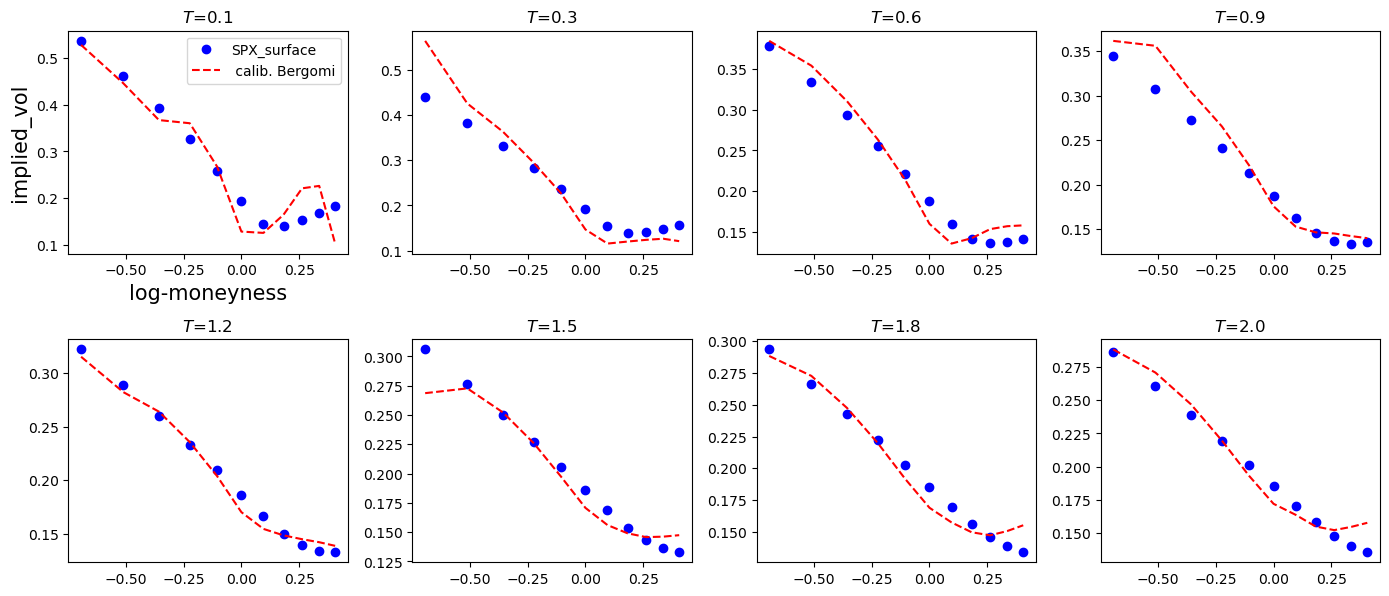

In [498]:
calib_surface = output_norm_transform_inv(NeuralNetwork(opt_res.x), y_mean, y_std)
calib_surface = np.abs(calib_surface)
plt.figure(1, figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(
        np.log(strikes / S0),
        spx_surface[i * strikes_dim : (i + 1) * strikes_dim],
        color="b",
        marker="o",
        linestyle="",
        label="SPX_surface",
    )
    plt.plot(
        np.log(strikes / S0),
        calib_surface[i * strikes_dim : (i + 1) * strikes_dim],
        "--r",
        label=" calib. Bergomi",
    )
    plt.title(r"$T$=%1.1f " % maturities[i])

    if i == 0:
        plt.legend()
        plt.xlabel("log-moneyness", size=15)
        plt.ylabel("implied_vol", size=15)
plt.tight_layout()
plt.show()

Fit on spx_surface is poor for the earlier maturietes where there were many NaN values but becomes more stable and accurate for the higher time horizons where there were fewer and fewer NaN implied vols from the call pricer.We Notice particularly at maturity T=0.1 and K=150 that the calibrated surface shows a sharp downward dip not present in the actual surface

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

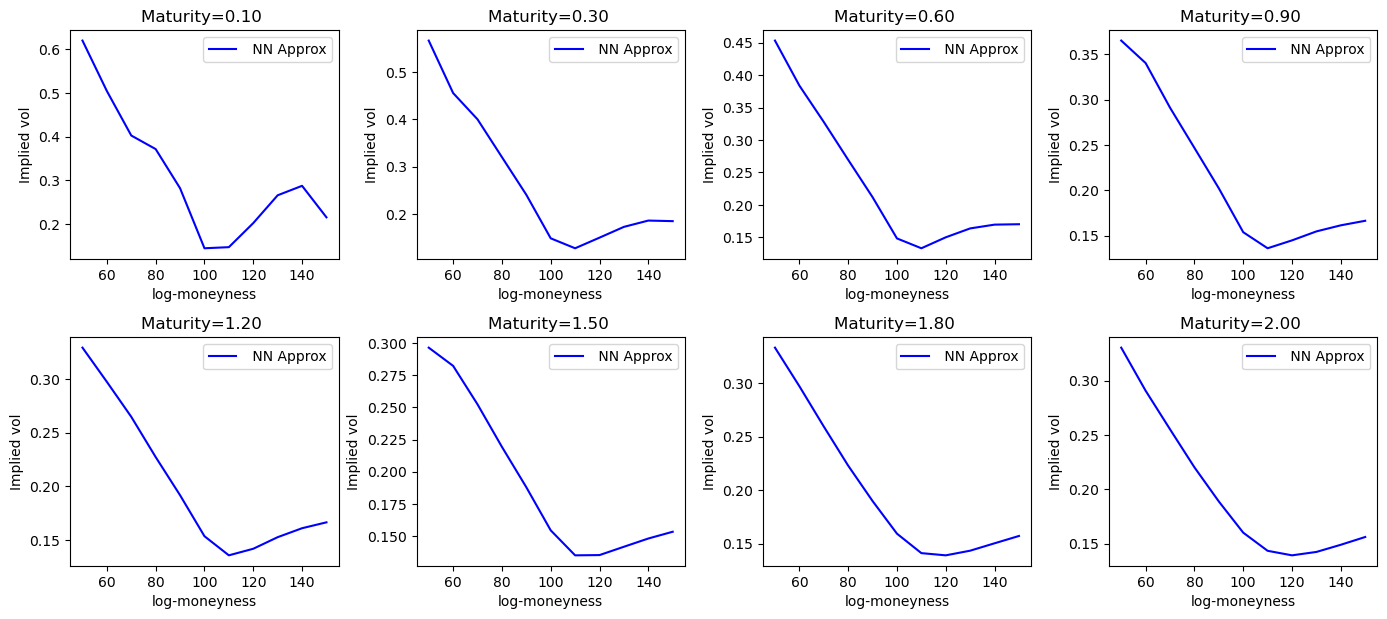

In [502]:
x0 = [0.06, 41.6, 18.2428, 3.43, -0.7]
plot_func(*x0)

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

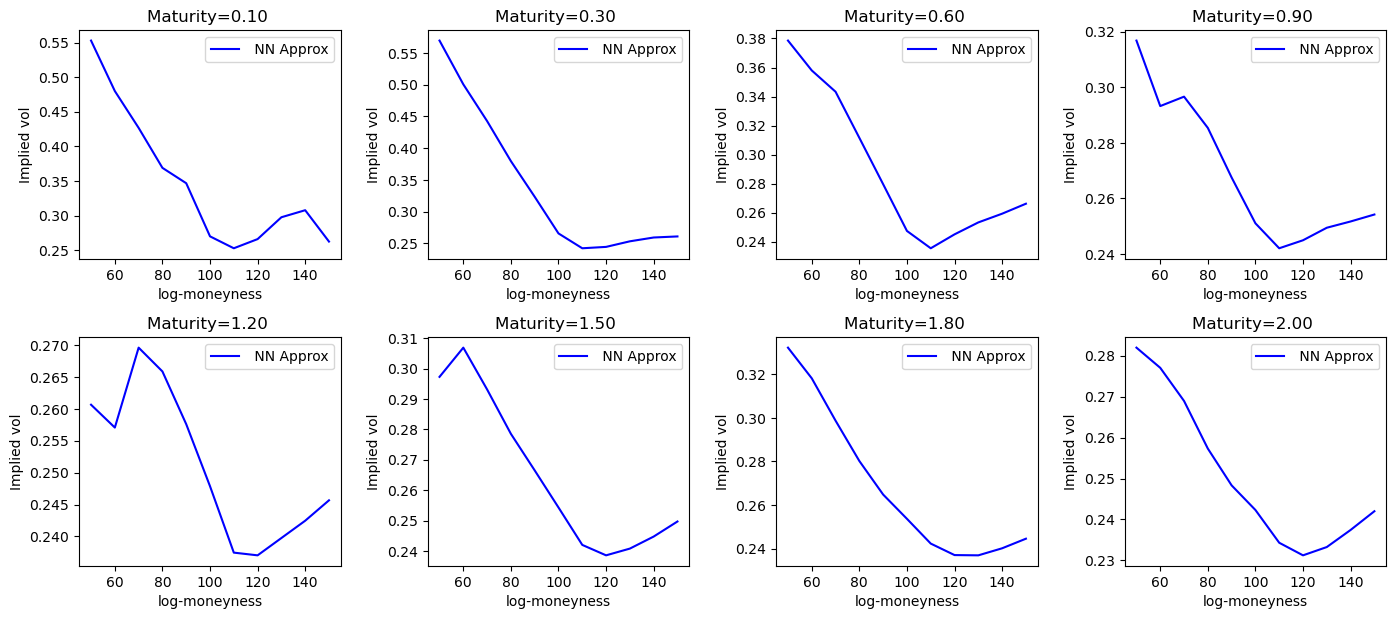

In [503]:
x0 = [0.1, 15.6, 5.5857, 2.2867, -0.4]
plot_func(*x0)

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

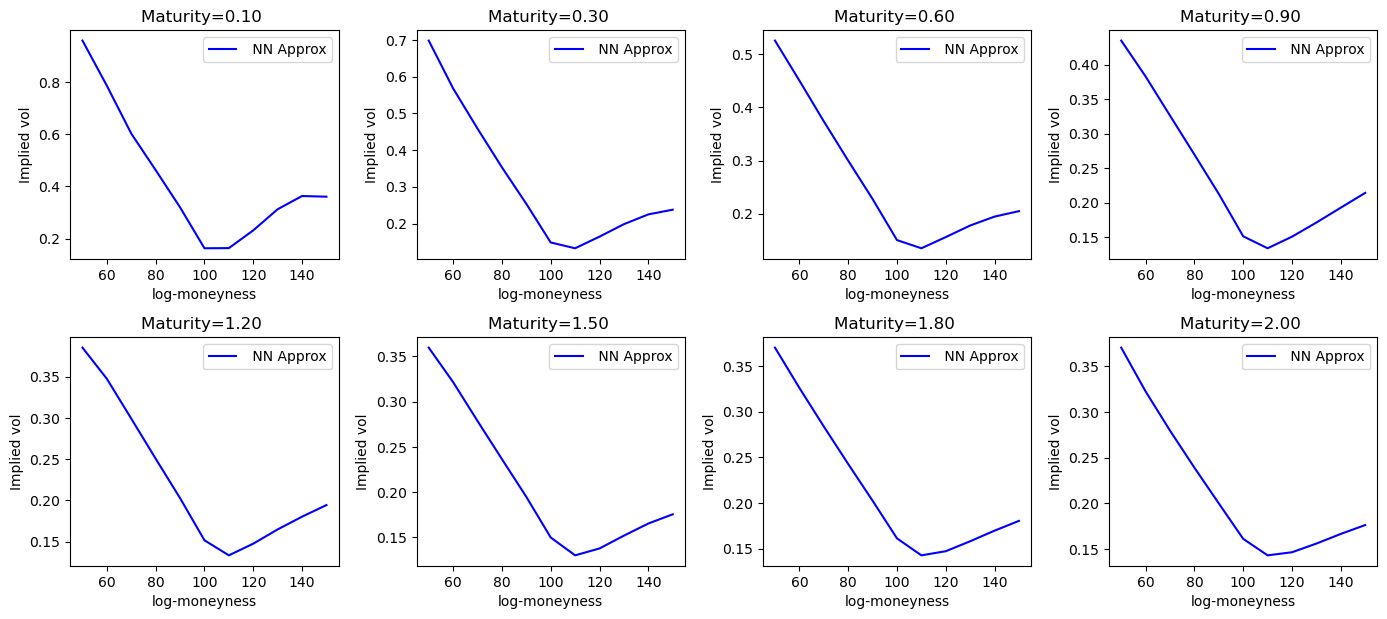

In [504]:
x0 = [0.2, 54.6, 31.3496, 4.5733, -0.8]
plot_func(*x0)

##### Due the lack of good rows of data maturity 0.1, we have significant error for those columnns only, specifically the values for strike in [50,60,70, 150]. The biggest cause of error in the entire model is that for T=0.1 and k=50 we have more than 80% of the values in our dataset being 0 due to the implied volitility beign out of range. We had to estimate these values using np.polyfit to fit to a parabola. The NN should have much better performance close to a log moneyness of zero 

# References

1)  Bruno Dupire. Arbitrage pricing with stochastic volatility. Société Générale, 1992

2)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 201

4) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218